# Model
Create neural network using Keras & TensorFlow

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

## Define L1 Loss function

In [ ]:
def smooth_L1_loss(y_true, y_pred):
    THRESHOLD = K.variable(1.0)
    mae = K.abs(y_true - y_pred)
    flag = K.greater(mae, THRESHOLD)
    loss = K.mean(K.switch(flag, (mae - 0.5), K.pow(mae, 2)), axis=-1)
    return loss

## Data Preparation

In [ ]:
X_train = pd.read_csv('processed data/predictors_train.csv', index_col = 0)
y_train = pd.read_csv('processed data/target_train.csv', names = ['price'])

X_test = pd.read_csv('processed data/predictors_test.csv', index_col = 0)
y_test = pd.read_csv('processed data/target_test.csv', names = ['price'])

In [ ]:
fft_cols = ['fft 3', 'fft 6', 'fft 9']  # list of fourier transform column names

#re-create entire microsoft adjusted closing price DataFrame
y = pd.read_csv('raw data/msft.csv', index_col=0)

y['price'] = y['5. adjusted close']

#re-create fourier transforms as np.complex128 (instead of converting existing columns)
close_fft = np.fft.fft(np.asarray(y['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    fft_df['fft {}'.format(num_)] = np.fft.ifft(fft_list_m10)
fft_df.drop(['fft'], axis = 1, inplace = True)
fft_df = fft_df.set_index(y.index)

for col in fft_cols:
    X_train[col] = fft_df[col].iloc[0:-501]
    X_test[col] = fft_df[col].iloc[-501:]

In [ ]:
#convert testing/training sets to numpy arrays
X_train = np.array(X_train.values)
y_train = np.array(y_train.values)

X_test = np.array(X_test.values)
y_test = np.array(y_test.values)

In [ ]:
#reshape data for input into the LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Build, Train, and Test Model

In [ ]:
sequence_length = 1  # number of days before predicting
n_features = X_train.shape[2]  # number of features in the data set
time_step = 1  # number of samples

In [ ]:
model = Sequential()
#2 layer stateful LSTM with 125 nodes and Xavier (glorot_uniform) activation and L1 loss function
model.add(LSTM(125, batch_input_shape=(sequence_length, time_step, n_features),
                       kernel_initializer='glorot_uniform', stateful=True, return_sequences=True))
model.add(LSTM(75, stateful=True))
#add dropout layer here
#add dense layer here
#add dropout layer here
model.add(Dense(1, input_shape=(75,)))  # single node dense output layer with prediction
model.compile(loss=smooth_L1_loss, optimizer='adam')

model.summary()  # show model summary

In [9]:
#fit model to training data
n_epochs = 200
for i in range(n_epochs):
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)

Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
prd = model.predict(X_test, batch_size=1)

In [11]:
mean_squared_error(y_test, prd)

1.766338391371839

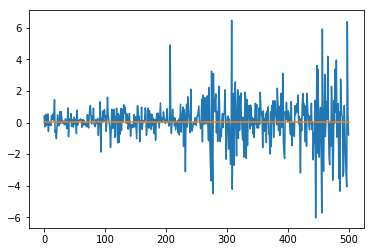

In [38]:
import matplotlib.pyplot as plt
plt.plot(y_test)
plt.plot(prd)
plt.show()

In [34]:
real[0]

59.9183